# Solution8：實作Efficientnet網路架構

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/taipeitechmmslab/MMSLAB-TF2/blob/master/Exercise/Solution8.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/taipeitechmmslab/MMSLAB-TF2/blob/master/Exercise/Solution8.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

### Import必要套件

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

---
## Keras Applications
### 創建EfficientNetB0網路架構
- 輸入大小(預設)：(224, 224, 3)
- 權重(預設)：`imagenet`
- 輸出類別(預設)：1000個類別

keras.applications API: https://www.tensorflow.org/api_docs/python/tf/keras/applications

※注意: EfficientNet支援`TensorFlow 2.3+`

In [2]:
model = tf.keras.applications.EfficientNetB0(include_top=True, weights='imagenet')

透過`model.summary`可以察看網路模型的每一層資訊：

In [3]:
model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

將網路模型儲存到TensorBoard上：

In [4]:
model_tb = tf.keras.callbacks.TensorBoard(log_dir='lab8-logs-efficientnetB0-keras')
model_tb.set_model(model)

### 資料前處理和輸出解碼

Import資料預處理和輸出解碼的函式：

In [5]:
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.efficientnet import decode_predictions

### 預測輸出結果

創建影像讀取的函式：讀取影像，並將影像大小縮放大224x224x3的尺寸。

In [6]:
def read_img(img_path, resize=(224,224)):
    img_string = tf.io.read_file(img_path)  # 讀取檔案
    img_decode = tf.image.decode_image(img_string)  # 將檔案以影像格式來解碼
    img_decode = tf.image.resize(img_decode, resize)  # 將影像resize到網路輸入大小
    # 將影像格式增加到4維(batch, height, width, channels)，模型預測要求格式
    img_decode = tf.expand_dims(img_decode, axis=0)
    return img_decode

從資料夾中讀取一張影像（elephant.jpg）作為測試：

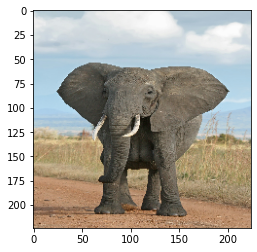

In [7]:
img_path = '../image/elephant.jpg'
img = read_img(img_path)  # 透過剛創建的函式讀取影像
plt.imshow(tf.cast(img, tf.uint8)[0])  # 透過matplotlib顯示圖片需將影像轉為Integers

預測結果：

In [8]:
img = preprocess_input(img)  # 影像前處理
preds = model.predict(img)  # 預測圖片
print("Predicted:", decode_predictions(preds, top=3)[0])  # 輸出預測最高的三個類別

Predicted: [('n02504458', 'African_elephant', 0.54815733), ('n01871265', 'tusker', 0.17353572), ('n02504013', 'Indian_elephant', 0.072621465)]


---
## TensorFlow Hub

Install:
```
pip install tensorflow-hub
```

Search:
https://tfhub.dev/

In [9]:
import tensorflow as tf
import tensorflow_hub as hub

### 創建EfficientNet B0模型

Model:
https://tfhub.dev/tensorflow/efficientnet/b0/classification/1

num_classes = 1001 classes of the classification from the original training
 
Image:height x width = 224 x 224 pixels, 3 RGB color values in the range 0~1

labels file: https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt

In [10]:
# EfficientNet B0預訓練模型的URL
module_url = "https://tfhub.dev/tensorflow/efficientnet/b0/classification/1"

# 創建一個Sequential Model，網路模型裡面包含了EfficientNet B0網路層
model = tf.keras.Sequential([
    # hub.KerasLayer將載入的EfficientNet B0模型封裝成網路層(Keras Layer)
    hub.KerasLayer(module_url, 
                   name='EfficientNetB0')  # 網路層名稱
])
model.build([None, 224, 224, 3])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EfficientNetB0 (KerasLayer)  (None, 1000)              5330564   
Total params: 5,330,564
Trainable params: 0
Non-trainable params: 5,330,564
_________________________________________________________________


### 資料前處理和輸出解碼

創建資料前處理函式：

In [12]:
def read_img(img_path, resize=(224,224)):
    img_string = tf.io.read_file(img_path)  # 讀取檔案
    img_decode = tf.image.decode_image(img_string)  # 將檔案以影像格式來解碼
    img_decode = tf.image.convert_image_dtype(img_decode, tf.float32)
    img_decode = tf.image.resize(img_decode, resize)  # 將影像resize到網路輸入大小
    # 將影像格式增加到4維(batch, height, width, channels)，模型預測要求格式
    img_decode = tf.expand_dims(img_decode, axis=0)  # 
    return img_decode

創建輸出解碼器：

In [13]:
# 下載ImageNet 的標籤檔
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
# 讀取標籤檔中的數據
with open(labels_path) as file:
    lines = file.read().splitlines()
print(lines)  # 顯示讀取的標籤

imagenet_labels = np.array(lines)  # 將標籤轉成numpy array做為網路輸出的解碼器

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'European fire salamander', 'common newt', 'eft', 'spotted salamander', 'axolotl', 'bullfrog', 'tree frog', 'tailed frog', 'loggerhead', 'leatherback turtle', 'mud turtle', 'terrapin', 'box turtle', 'banded gecko', 'common iguana', 'American chameleon', 'whiptail', 'agama', 'frilled lizard', 'alligator lizard', 'Gila monster', 'green lizard', 'African chameleon', 'Komodo dragon', 'African crocodile', 'American alligator', 'triceratops', 'thunder snake', 'ringneck snake', 'hognose snake', 'green snake', 'king snake', 'garter snake', 'water snake', 'vine snake', 'night snake', 'boa constrictor', 'rock python', 'Indian cobra', 'green mamba', 'sea snake', 'horned viper', '

### 預測輸出結果

從資料夾中讀取一張影像（elephant.jpg）作為測試：

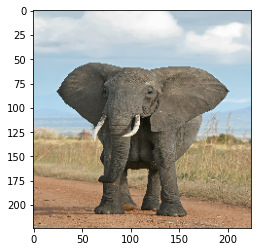

In [14]:
img_path = '../image/elephant.jpg'
img = read_img(img_path)  # 透過剛創建的函式讀取影像
plt.imshow(img[0])

預測結果：

In [15]:
preds = model.predict(img)  # 預測圖片
index = np.argmax(preds)  # 取得預測結果最大的Index
print("Predicted:", imagenet_labels[index])  # 透過解碼器將輸出轉成標籤

Predicted: Indian elephant


顯示最好的三個預測：

In [16]:
# 取得預測結果最大的三個indexs
top3_indexs = np.argsort(preds)[0, ::-1][:3]  
print("Predicted:", imagenet_labels[top3_indexs+1])  # 透過解碼器將輸出轉成標籤

Predicted: ['African elephant' 'tusker' 'Indian elephant']
